# Chapter 23: Dynamic of Networks: Temporal Networks

Goal of today's class:
1. Create temporal networks from data
2. Learn key properties of temporal networks like inter-event time distributions, burstiness, etc.
3. Introduce the activity-driven network model

*Acknowledgement: Some of the material in this lesson is based on a previous course offered by Matteo Chinazzi and Qian Zhang.*
__________

1. Come in. Sit down. Open Teams.
2. Make sure your notebook from last class is saved.
3. Open up the Jupyter Lab server.
4. Open up the Jupyter Lab terminal.
5. Activate Conda: `module load anaconda3/2022.05`
6. Activate the shared virtual environment: `source activate /courses/PHYS7332.202510/shared/phys7332-env/`
7. Run `python3 git_fixer2.py`
8. Github:
    - git status (figure out what files have changed)
    - git add ... (add the file that you changed, aka the `_MODIFIED` one(s))
    - git commit -m "your changes"
    - git push origin main
________

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc
rc('axes', axisbelow=True)
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

### To begin: a challenge.

In the `data` folder, there is a file `sp.tsv`.
1. Use `pandas` to load this dataset.
2. Name the columns ['timestamp', 'node_i', 'node_j']
3. Plot the number of connections between pairs of nodes per unit time.

**You have until 11:15am to create a figure.**

In [2]:
pass

In [3]:
pass

____
## Temporal Networks (Time-Varying Networks)

### To motivate, what does *contact tracing* actually look like in an epidemic?

![](images/contact_tracing.png)

_________

### Temporal networks are everywhere

- Person-to-person communication
    - I. Emails
    - II.Mobile phone calls, or messages
    - III.Various online activities
- One-to many communication
   - I. Twitter
   - II.Instagram
   - III.Wikipedia
- Physical Proximity
   - I. Reality mining project
   - II. SocioPatterns project
- Cell biology
   - I. Proteins interactions
   - II. Gene regulatory networks
   - III. Metabolic networks
- Infrastructural Systems
   - I. Air transportation
   - II. Train routes
   - III. Bus routes
- Neural and brain networks
   - I. Activation and correlation among different brain areas
   - II. Neuronal connectivity
- Ecological systems
   - I. Food webs
   - II. Mobility and proximity of animals


____
### Time is relative!
* $t_G$ describes the evolution of the network
* $t_P$ describes the evolution of the process
* scale of $t_G/t_P$:

<!-- ![](images/timescale.png) -->

_________
### Representation
* Static network: adjacency matrix $A_{ij}$

* Temporal network: adjacency matrix as a function of time $A_{ij}(t)$


<!-- ### Shortest path

![](images/shortestpath1.png)
__________
 -->

<!-- ![](images/shortestpath2.png)
__________
 -->

<!-- ![](images/shortestpath3.png)
__________
 -->

<!-- ![](images/shortestpath4.png)
__________ -->

### Connected components

I. Strongly connected: all $i$ and $j$ reachable within $T$ (in both directions)

II. Weakly connected: all $i$ and $j$ reachable within $T$ (in at least one direction)

### Centralities

I. Closeness: 
$$c^{c}(i) = \frac{N-1}{\sum_{i\neq j} d_{ij}} \qquad \Rightarrow \qquad c^{c}(i, T) = \frac{N-1}{\sum_{i\neq j} \lambda_{ijT}}$$

II. Betweenness:
* $g_{j,k}$ is the number of shortest paths between nodes $j$ and $k$
* $g_{j,k}(i)$ is the number of shortest paths between nodes $j$ and $k$ going through $i$ 
* let if $j=k$, $g_{jk} = 1$, and if $i\in\{j,k\}$, $g_{j,k}(i)=0$

$$c^b(i) = \sum \frac{g_{j,k}(i)}{g_{j,k}} \qquad \Rightarrow \qquad c^b(i, T) = \sum \frac{g_{j,k}(i, T)}{g_{j,k}(T)}$$


______
### Loading temporal network data

Revisiting the temporal network from above...

The **High School Contact Network Dataset** from the [SocioPatterns](https://www.sociopatterns.org/) project captures the temporal interactions between students in a French high school over the course of several days. The dataset was collected using wearable proximity sensors that recorded face-to-face interactions among students at 20-second intervals. Each interaction includes the IDs of the two individuals involved and the timestamp of the interaction in seconds since the start of the observation period.

This dataset is widely used in network science research to study temporal networks, social interactions, and spreading processes (e.g., information or disease propagation). Its temporal resolution and rich interaction data make it an excellent resource for exploring dynamic graph structures and understanding social behavior in structured environments like schools.

**References**
- Cattuto, C., Van den Broeck, W., Barrat, A., Colizza, V., Pinton, J. F., & Vespignani, A. (2010). Dynamics of person-to-person interactions from distributed RFID sensor networks. *PloS One*, 5(7), e11596. https://doi.org/10.1371/journal.pone.0011596
- Starnini, M., Baronchelli, A., & Pastor-Satorras, R. (2013). Modeling human dynamics of face-to-face interaction networks. *Physical Review Letters*, 110(16), 168701. https://doi.org/10.1103/PhysRevLett.110.168701

In [4]:
# time \t node_i \t node_j
tdf = pd.read_csv('data/sp.tsv',sep='\t',header=None,
                  names=['timestamp','node_i','node_j'])[['node_i','node_j','timestamp']]

In [5]:
bin_size = 60*1 # 1 minute
tdf["time_bin"] = (tdf['timestamp'] // bin_size) * bin_size

In [6]:
tdf

node_i  node_j  timestamp  time_bin
0        1170    1644          0         0
1        1170    1613         20         0
2        1170    1644        260       240
3        1181    1651        380       360
4        1108    1190        460       420
...       ...     ...        ...       ...
45042     880     887     729200    729180
45043     854     869     729200    729180
45044     880     887     729220    729180
45045     620     669     729380    729360
45046     669     677     729500    729480

[45047 rows x 4 columns]

In [7]:
aggregate_counts = tdf["time_bin"].value_counts().sort_index()
aggregate_counts

time_bin
0         2
240       1
360       1
420       1
600       2
         ..
729000    4
729060    3
729180    7
729360    1
729480    1
Name: count, Length: 4135, dtype: int64

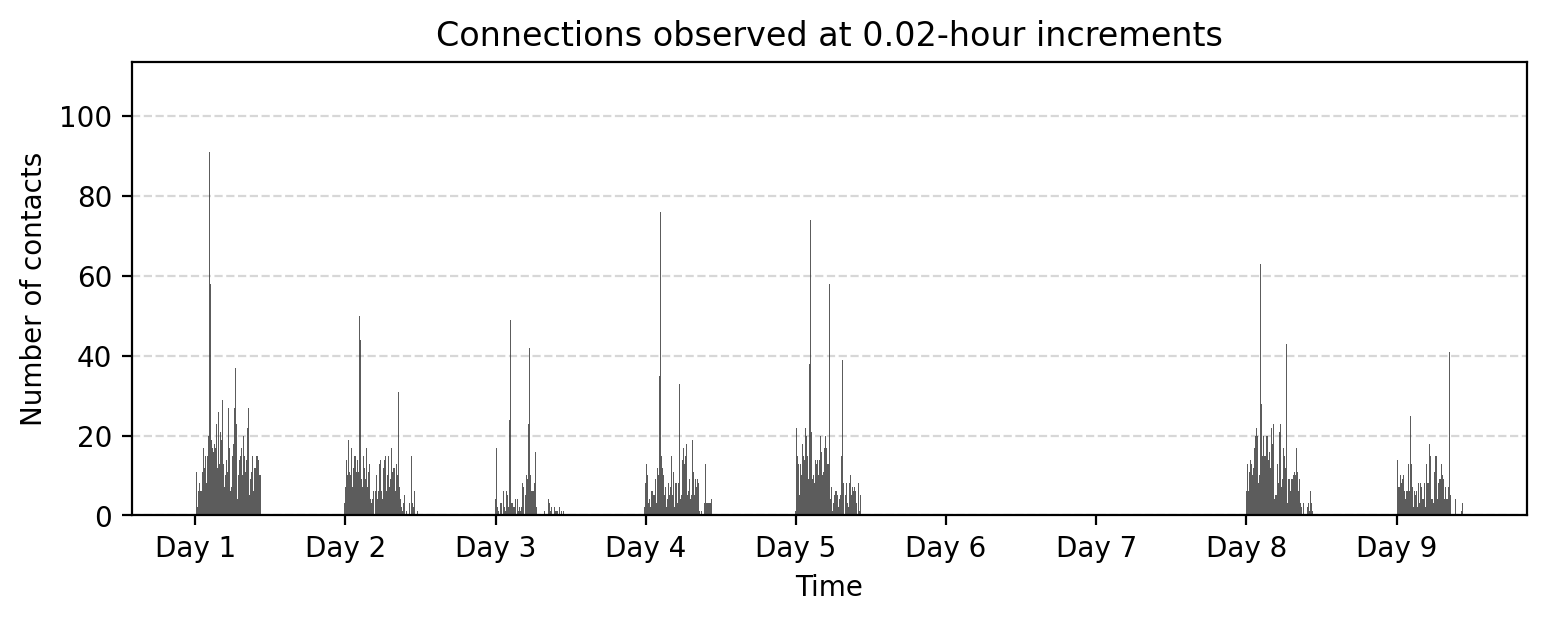

In [8]:
fig, ax = plt.subplots(1,1,figsize=(9,3),dpi=200)

ax.bar(aggregate_counts.index, aggregate_counts.values, width=bin_size, color='.2', alpha=0.8)

ax.grid(axis="y", linestyle="--", alpha=0.5)
# Set x-ticks at absolute 24-hour intervals
start_time = aggregate_counts.index.min()
end_time = aggregate_counts.index.max()

# Generate 24-hour spaced timestamps
tick_positions = range(start_time, end_time + 1, 24 * 3600)  # Step by 24 hours (in seconds)
tick_labels = ['Day %i'%i for i in range(1,len(tick_positions)+1)]

# Set ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

ax.set_title("Connections observed at %.2f-hour increments"%(bin_size/(3600)))
ax.set_xlabel("Time")
ax.set_ylabel("Number of contacts")


plt.show()

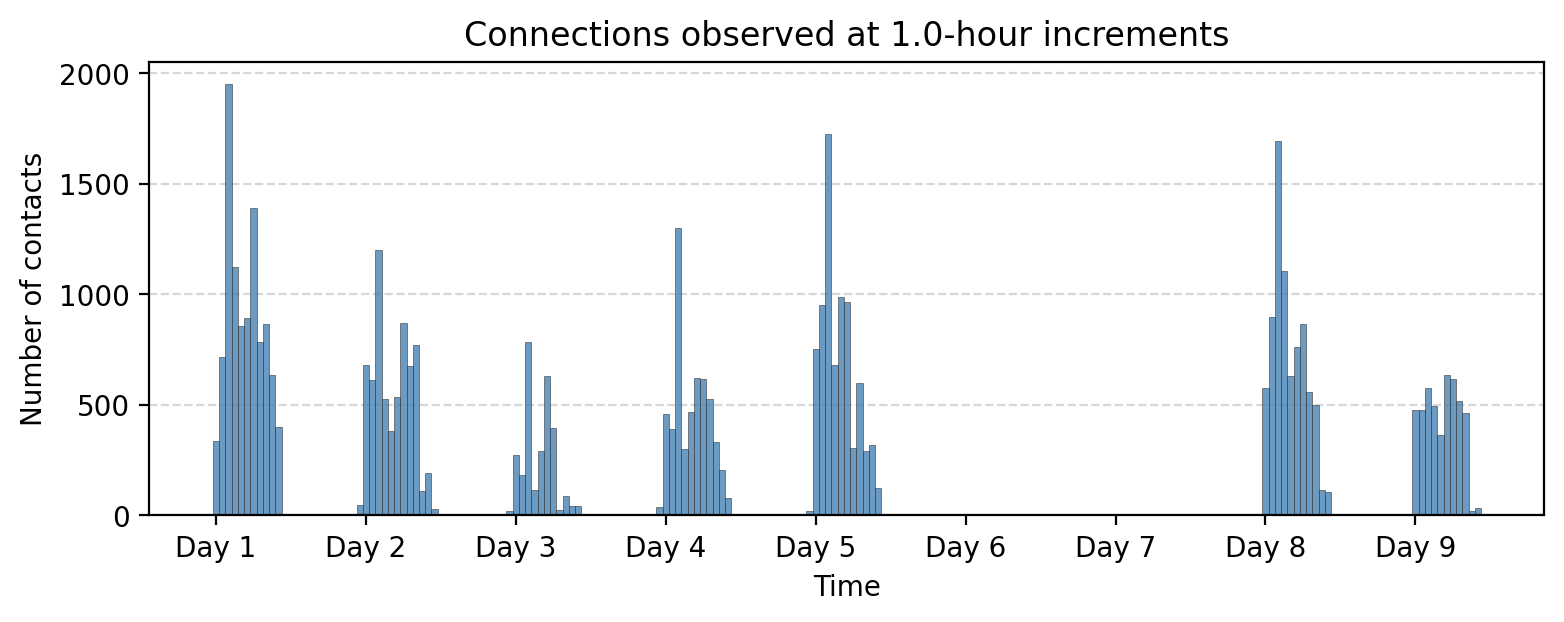

In [9]:
bin_size = 60*60 # 1 hour

tdf["time_bin"] = (tdf['timestamp'] // bin_size) * bin_size

aggregate_counts = tdf["time_bin"].value_counts().sort_index()

fig, ax = plt.subplots(1,1,figsize=(9,3),dpi=200)

ax.bar(aggregate_counts.index, aggregate_counts.values,
       width=bin_size, color='steelblue', alpha=0.8, ec='.2', lw=0.25)

ax.grid(axis="y", linestyle="--", alpha=0.5)
# Set x-ticks at absolute 24-hour intervals
start_time = aggregate_counts.index.min()
end_time = aggregate_counts.index.max()

# Generate 24-hour spaced timestamps
tick_positions = range(start_time, end_time + 1, 24 * 3600)  # Step by 24 hours (in seconds)
tick_labels = ['Day %i'%i for i in range(1,len(tick_positions)+1)]

# Set ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

ax.set_title("Connections observed at %.1f-hour increments"%(bin_size/(3600)))
ax.set_xlabel("Time")
ax.set_ylabel("Number of contacts")


plt.show()

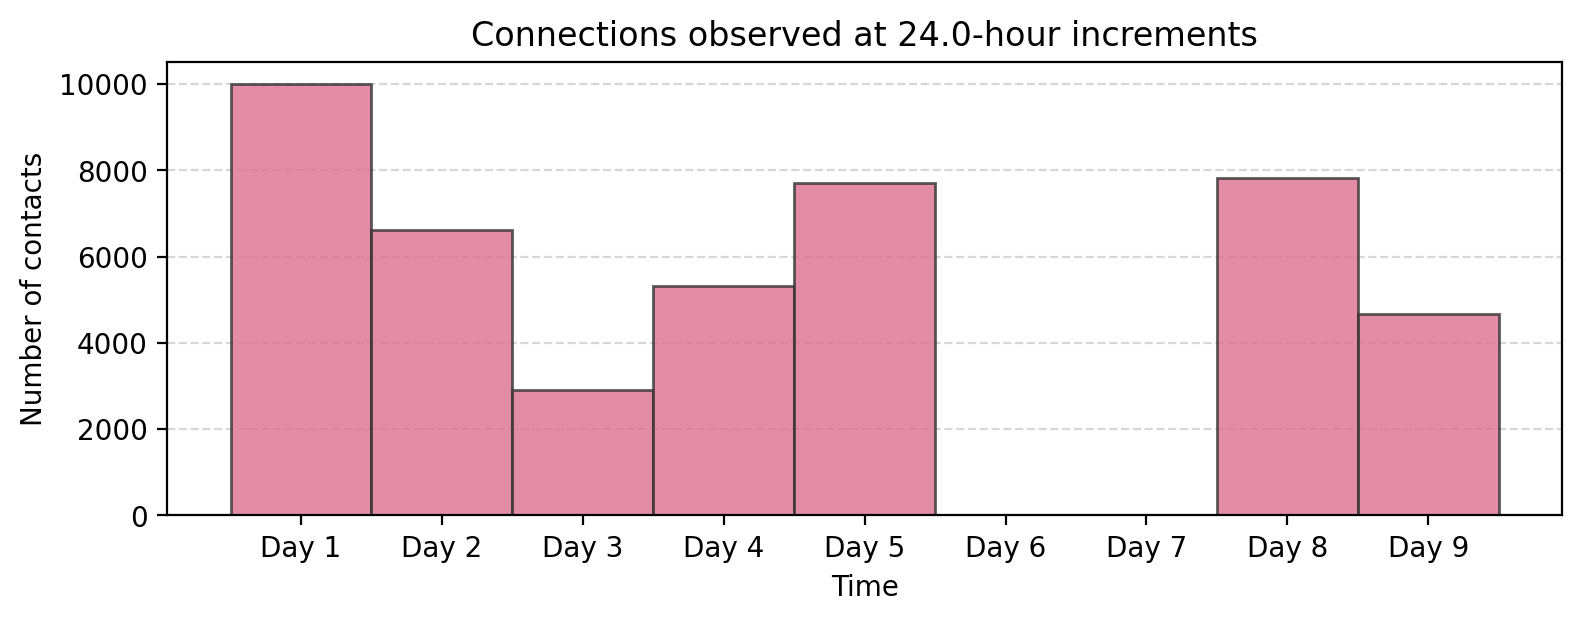

In [10]:
bin_size = 60*60*24 # 24 hour

tdf["time_bin"] = (tdf['timestamp'] // bin_size) * bin_size

aggregate_counts = tdf["time_bin"].value_counts().sort_index()

fig, ax = plt.subplots(1,1,figsize=(9,3),dpi=200)

ax.bar(aggregate_counts.index, aggregate_counts.values, width=bin_size,
       color='palevioletred', alpha=0.8, ec='.2')

ax.grid(axis="y", linestyle="--", alpha=0.5)
# Set x-ticks at absolute 24-hour intervals
start_time = aggregate_counts.index.min()
end_time = aggregate_counts.index.max()

# Generate 24-hour spaced timestamps
tick_positions = range(start_time, end_time + 1, 24 * 3600)  # Step by 24 hours (in seconds)
tick_labels = ['Day %i'%i for i in range(1,len(tick_positions)+1)]

# Set ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

ax.set_title("Connections observed at %.1f-hour increments"%(bin_size/(3600)))
ax.set_xlabel("Time")
ax.set_ylabel("Number of contacts")


plt.show()

____
### But what about the network!

In [11]:
def temporal_network_from_data(
    data,
    aggregation="all",
    interval_size=1,
    time_window=None,
    custom_slices=None,
    directed=False,
    multigraph=False,
    column_names=None
):
    """
    Convert temporal edge data into NetworkX graph objects with flexible temporal aggregation.

    This function processes temporal edge data (provided as a DataFrame, CSV file, or NumPy array)
    to create NetworkX graphs. It supports various temporal aggregation methods, including grouping
    by fixed intervals, custom time slices, or a single aggregated graph for all data.

    Parameters:
    ----------
    data : pd.DataFrame, str, or np.ndarray
        Input temporal edge data. Can be:
        - A Pandas DataFrame with required columns: 'node_i', 'node_j', 'timestamp'.
        - A file path to a CSV file (requires `column_names` to be specified).
        - A NumPy array with columns matching the required structure (requires `column_names`).

    aggregation : str, optional
        Temporal aggregation method. Options are:
        - 'interval': Group data into fixed time intervals (specified by `interval_size`).
        - 'custom': Group data based on custom time slices (specified by `custom_slices`).
        - 'all': Aggregate all data into a single graph.
        Default is 'all'.

    interval_size : int, optional
        Size of the time intervals (in seconds) for 'interval' aggregation. Default is 1.

    time_window : tuple, optional
        A tuple `(start, stop)` to filter timestamps within a specific range (in seconds).
        Default is None, which includes all timestamps.

    custom_slices : list, optional
        List of custom slice sizes (in seconds) for 'custom' aggregation. For example, [3600, 7200]
        would create two time bins of 1 hour and 2 hours, respectively. Default is None.

    directed : bool, optional
        If True, creates directed graphs (DiGraph or MultiDiGraph). Default is False.

    multigraph : bool, optional
        If True, creates MultiGraphs or MultiDiGraphs to allow parallel edges. If False,
        standard Graph or DiGraph objects are created, and weights are aggregated. Default is False.

    column_names : list, optional
        Required when `data` is a CSV file or NumPy array. Specifies the column names as:
        ['node_i', 'node_j', 'timestamp', (optional) 'weight'].

    Returns:
    -------
    dict or networkx.Graph
        - If data is aggregated into multiple time bins (e.g., 'interval' or 'custom'), returns a
          dictionary where keys are time bins and values are NetworkX graph objects.
        - If data is aggregated into a single graph (e.g., 'all'), returns a single NetworkX graph.

    Raises:
    ------
    ValueError
        - If required columns ('node_i', 'node_j', 'timestamp') are missing.
        - If `custom_slices` is not provided for 'custom' aggregation.
        - If `column_names` is not provided when input data is a CSV file or NumPy array.

    TypeError
        - If input data is not a Pandas DataFrame, a CSV file path, or a NumPy array.

    Examples:
    --------
    1. Aggregating into a single graph:
        >>> G_agg = temporal_network_from_data(data, aggregation="all")

    2. Aggregating into 1-hour intervals:
        >>> G_interval = temporal_network_from_data(data, aggregation="interval", interval_size=3600)

    3. Using custom time slices:
        >>> G_custom = temporal_network_from_data(data, aggregation="custom", custom_slices=[3600, 7200])

    4. Handling a CSV file:
        >>> G_csv = temporal_network_from_data("edges.csv",
                                               column_names=["node_i","node_j","timestamp","weight"])

    Notes:
    -----
    - The 'weight' column, if present, is aggregated for standard graphs (not MultiGraphs).
    - The timestamp column must be numeric and represents time in seconds.
    """

    # Handle data input
    if isinstance(data, pd.DataFrame):
        df = data
    elif isinstance(data, str):  # CSV file path
        if column_names is None:
            raise ValueError("Column names must be provided when reading from a CSV file.")
        df = pd.read_csv(data, names=column_names)
    elif isinstance(data, np.ndarray):  # NumPy array
        if column_names is None:
            raise ValueError("Column names must be provided for a NumPy array.")
        df = pd.DataFrame(data, columns=column_names)
    else:
        raise TypeError("Input data must be a Pandas DataFrame, a CSV file path, or a NumPy array.")
    
    # Check required columns
    required_columns = {"node_i", "node_j", "timestamp"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Input data must contain {required_columns} columns.")
    
    # Filter by time window
    if time_window:
        start, stop = time_window
        df = df[(df["timestamp"] >= start) & (df["timestamp"] <= stop)]
    
    # Determine time bins
    if aggregation == "interval":
        df["time_bin"] = (df["timestamp"] // interval_size) * interval_size
    elif aggregation == "custom":
        if not custom_slices:
            raise ValueError("Custom slices must be provided for 'custom' aggregation.")
        time_bins = []
        current_start = df["timestamp"].min()
        for slice_size in custom_slices:
            current_end = current_start + slice_size
            time_bins.append((current_start, current_end))
            current_start = current_end
        
        # Assign rows to custom time bins
        def assign_to_custom_bin(ts):
            for i, (start, end) in enumerate(time_bins):
                if start <= ts < end:
                    return i
            return None  # Outside custom slices
        
        df["time_bin"] = df["timestamp"].apply(assign_to_custom_bin)
        df = df[df["time_bin"].notnull()]  # Remove rows outside custom slices
    elif aggregation == "all":
        df["time_bin"] = "all"  # Single graph for all data
    else:
        raise ValueError(f"Unsupported aggregation type: {aggregation}")
    
    # Group by time bins and create graphs
    graphs = {}
    for time_bin, group in df.groupby("time_bin"):
        # Determine graph type
        if multigraph:
            G = nx.MultiDiGraph() if directed else nx.MultiGraph()
        else:
            G = nx.DiGraph() if directed else nx.Graph()
        
        # Aggregate weights if multigraph is False
        if not multigraph:
            edge_weights = (
                group.groupby(["node_i", "node_j"])
                .agg(weight=("weight", "sum") if "weight" in group.columns else ("timestamp", "size"))
                .reset_index()
            )
            for _, row in edge_weights.iterrows():
                G.add_edge(row["node_i"], row["node_j"], weight=row["weight"])
        else:  # Add edges directly without aggregation
            for _, row in group.iterrows():
                G.add_edge(
                    row["node_i"], 
                    row["node_j"], 
                    weight=row.get("weight", 1), 
                    timestamp=row["timestamp"]
                )
        
        graphs[time_bin] = G
    
    # Return a single graph if no aggregation
    if aggregation == "all" or (aggregation == "custom" and len(graphs) == 1):
        return graphs["all"]

    return graphs


Test out our temporal network creation function! Visualize the **aggregated** network.

In [12]:
G_agg = temporal_network_from_data(tdf, aggregation="all")

In [13]:
np.random.seed(5)
pos = nx.spring_layout(G_agg, k=1.0, iterations=200, threshold=0.005)

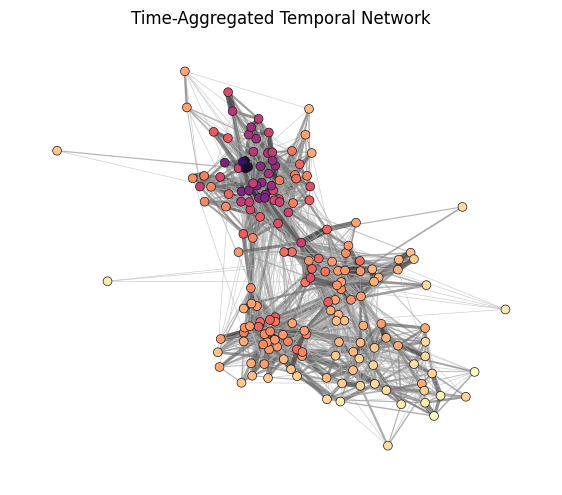

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7,6), dpi=100)

# Extract edge weights
ews = np.array(list(nx.get_edge_attributes(G_agg, 'weight').values()))
ews = ews ** 0.3 - 0.5 # Scale edge width non-linearly for visualization

# Relate edge colors to the normalized edge width and adjust with an exponent
ecs = (ews / max(ews)) ** 0.15

# Calculate eigenvector centrality for nodes, adjust with an exponent for better visualization
ncs = np.array(list(nx.eigenvector_centrality(G_agg, weight='weight').values())) ** 0.1
ncs = (ncs-min(ncs))/(max(ncs)-min(ncs))


# Draw the nodes of the network
nx.draw_networkx_nodes(
    G_agg,                  # The aggregated temporal network graph
    pos,                    # The positions of nodes (should be precomputed separately)
    node_color=ncs,         # Color nodes based on their eigenvector centrality scores
    node_size=40,           # Size of the nodes
    linewidths=0.5,         # Border width of nodes
    edgecolors='.1',        # Edge color of the nodes (dark grey)
    cmap=plt.cm.magma_r,    # Node colormap
    vmin=0, vmax=1.1,
    ax=ax
)

nx.draw_networkx_edges(
    G_agg,                              # The aggregated temporal network graph
    pos,                                # The positions of nodes
    width=ews,                          # Edge widths calculated above
    edge_color=ecs,                     # Edge colors calculated above
    edge_cmap=plt.cm.Greys,             # Use the Greys colormap for edges
    edge_vmin=0.45,                     # Minimum value for edge color normalization
    edge_vmax=1.0,                      # Maximum value for edge color normalization
    alpha=0.7,                          # Transparency of edges
    ax=ax
)

ax.set_title('Time-Aggregated Temporal Network')
ax.set_axis_off()


plt.show()

What about if we want a snapshot of the temporal network? E.g. the first hour?

In [15]:
day = 0
int_size = 60*60
G_t = temporal_network_from_data(tdf, 
                                 aggregation="interval",  # Options: 'interval', 'custom', 'all'
                                 interval_size=int_size, # Size of the time interval for 'interval' aggregation
                                 time_window=None,  # Tuple (start, stop) to restrict aggregation to specific time range
                                 custom_slices=None,  # List of custom slice sizes for aggregation
                                 directed=False,  # Create directed graph
                                 multigraph=False,  # Create a MultiGraph or MultiDiGraph instead of Graph/DiGraph
                                 column_names=None)  # Required if `data` is a CSV or NumPy array

In [16]:
G_t

{0: <networkx.classes.graph.Graph at 0x7fd369f38a90>,
 3600: <networkx.classes.graph.Graph at 0x7fd369f38460>,
 7200: <networkx.classes.graph.Graph at 0x7fd369f38af0>,
 10800: <networkx.classes.graph.Graph at 0x7fd3180dc5e0>,
 14400: <networkx.classes.graph.Graph at 0x7fd369f38f10>,
 18000: <networkx.classes.graph.Graph at 0x7fd369f38a60>,
 21600: <networkx.classes.graph.Graph at 0x7fd368dd9af0>,
 25200: <networkx.classes.graph.Graph at 0x7fd348abba60>,
 28800: <networkx.classes.graph.Graph at 0x7fd348abbc40>,
 32400: <networkx.classes.graph.Graph at 0x7fd2fa42ea00>,
 36000: <networkx.classes.graph.Graph at 0x7fd348abbb20>,
 82800: <networkx.classes.graph.Graph at 0x7fd348abef40>,
 86400: <networkx.classes.graph.Graph at 0x7fd348abef10>,
 90000: <networkx.classes.graph.Graph at 0x7fd2fa42ad90>,
 93600: <networkx.classes.graph.Graph at 0x7fd2f9c640d0>,
 97200: <networkx.classes.graph.Graph at 0x7fd348abe730>,
 100800: <networkx.classes.graph.Graph at 0x7fd2fa42a190>,
 104400: <networkx.

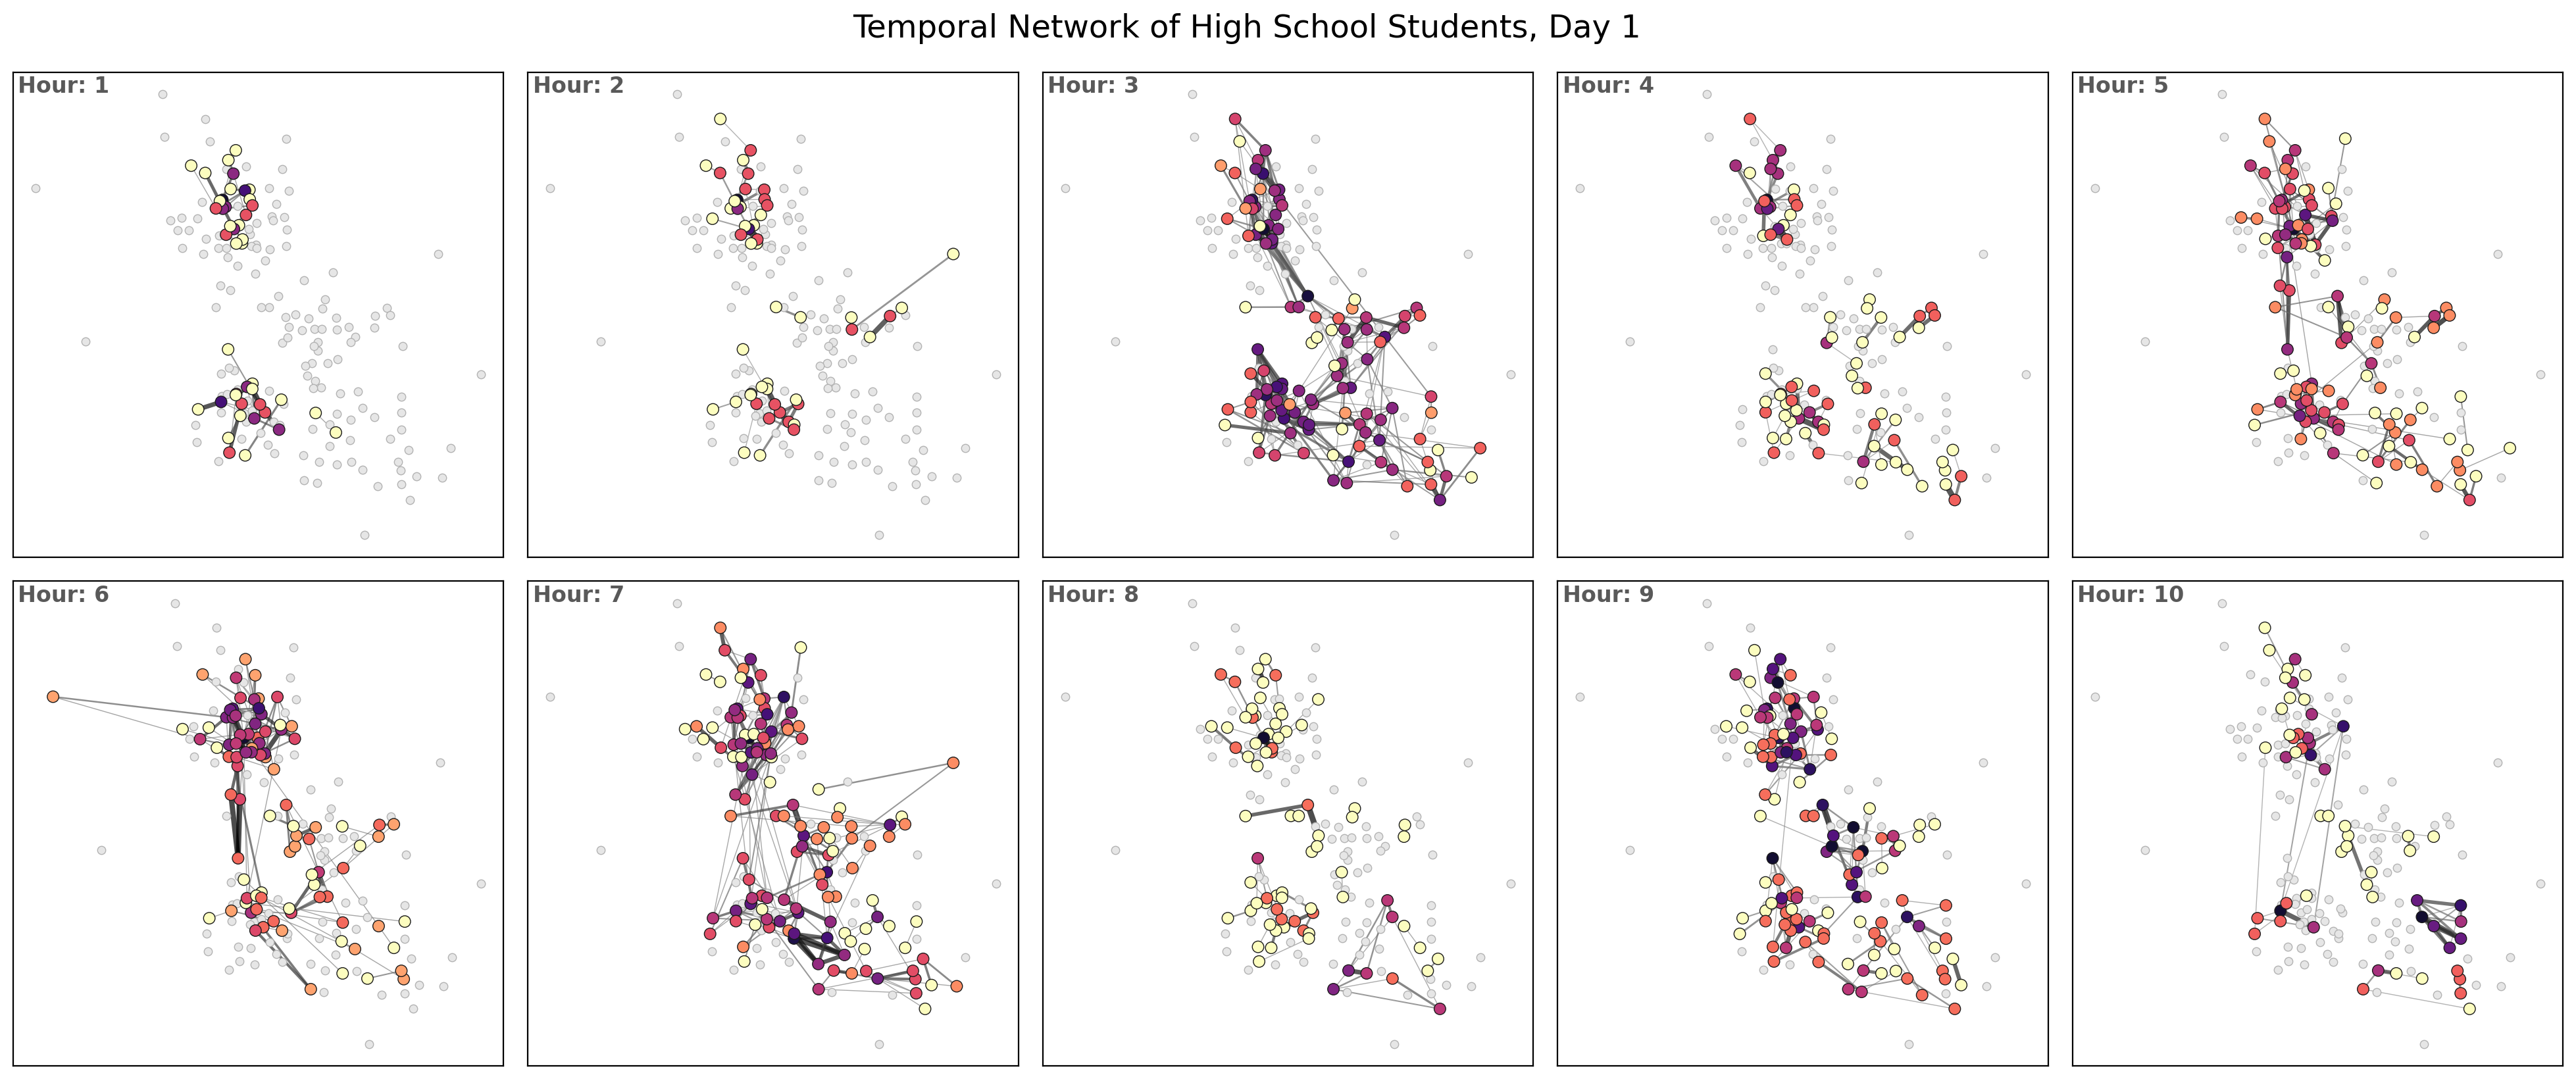

In [17]:
import itertools as it
nrows = 2
ncols = 5
hours_to_plot = nrows*ncols

fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows), dpi=200)
tups = list(it.product(range(nrows), range(ncols)))
plt.subplots_adjust(wspace=0.05, hspace=0.05)


for ti, t in enumerate(list(G_t.keys())[:hours_to_plot]):

    a = tups[ti]
    Gt = G_t[t]

    nx.draw_networkx_nodes(G_agg, pos, node_color='.9',
                           node_size=20, linewidths=0.5, edgecolors='.7', ax=ax[a])

    ews = np.array(list(nx.get_edge_attributes(Gt, 'weight').values()))
    ews = ews ** 0.3 - 0.5 # Scale edge width non-linearly for visualization
    ecs = (ews / max(ews)) ** 0.15
    ncs = np.array(list(nx.degree_centrality(Gt).values())) ** 0.1
    ncs = (ncs-min(ncs))/(max(ncs)-min(ncs))

    nx.draw_networkx_nodes(Gt, pos, node_color=ncs, node_size=40, linewidths=0.5,
                           edgecolors='.1', cmap=plt.cm.magma_r, vmin=0, vmax=1.1, ax=ax[a])
    nx.draw_networkx_edges(Gt, pos, width=ews, edge_color=ecs, edge_cmap=plt.cm.Greys,
                           edge_vmin=0.45, edge_vmax=1.0, alpha=0.7, ax=ax[a])

    ax[a].set_title('Hour: %i'%(ti+1), ha='left', va='top', x=0.01,
                    fontweight='bold', y=0.97, color='.35')

plt.suptitle('Temporal Network of High School Students, Day %i'%(day+1), y=0.925, fontsize='xx-large')

plt.show()

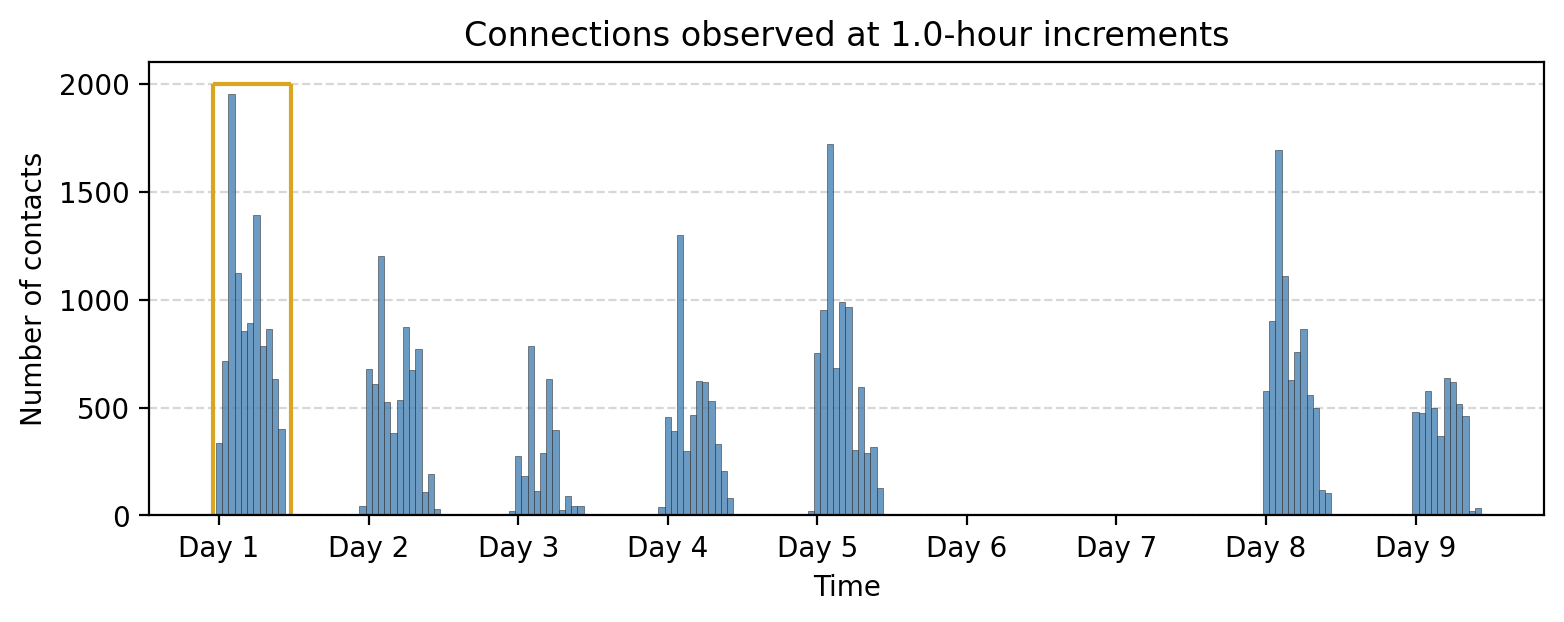

In [18]:
bin_size = 60*60 # 1 hour

tdf["time_bin"] = (tdf['timestamp'] // bin_size) * bin_size

aggregate_counts = tdf["time_bin"].value_counts().sort_index()

fig, ax = plt.subplots(1,1,figsize=(9,3),dpi=200)

ax.bar(aggregate_counts.index, aggregate_counts.values,
       width=bin_size, color='steelblue', alpha=0.8, ec='.2', lw=0.25)

ax.vlines(-60*60, 0, 2000, color='goldenrod')
ax.hlines(2000, -60*60, 60*60*11.5, color='goldenrod')
ax.vlines(60*60*11.5, 0, 2000, color='goldenrod')

ax.grid(axis="y", linestyle="--", alpha=0.5)
# Set x-ticks at absolute 24-hour intervals
start_time = aggregate_counts.index.min()
end_time = aggregate_counts.index.max()

# Generate 24-hour spaced timestamps
tick_positions = range(start_time, end_time + 1, 24 * 3600)  # Step by 24 hours (in seconds)
tick_labels = ['Day %i'%i for i in range(1,len(tick_positions)+1)]

# Set ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

ax.set_title("Connections observed at %.1f-hour increments"%(bin_size/(3600)))
ax.set_xlabel("Time")
ax.set_ylabel("Number of contacts")


plt.show()

_______

In [19]:
def get_binning(data, num_bins=50, is_pmf=False, log_binning=False, threshold=0):
    """
    Bins the input data and calculates the probability mass function (PMF) or 
    probability density function (PDF) over the bins. Supports both linear and 
    logarithmic binning.

    Parameters
    ----------
    data : array-like
        The data to be binned, typically a list or numpy array of values.
    num_bins : int, optional
        The number of bins to use for binning the data (default is 15).
    is_pmf : bool, optional
        If True, computes the probability mass function (PMF) by normalizing 
        histogram counts to sum to 1. If False, computes the probability density 
        function (PDF) by normalizing the density of the bins (default is True).
    log_binning : bool, optional
        If True, uses logarithmic binning with log-spaced bins. If False, uses 
        linear binning (default is False).
    threshold : float, optional
        Only values greater than `threshold` will be included in the binning, 
        allowing for the removal of isolated nodes or outliers (default is 0).
    
    Returns
    -------
    x : numpy.ndarray
        The bin centers, adjusted to be the midpoint of each bin.
    p : numpy.ndarray
        The computed PMF or PDF values for each bin.
    
    Notes
    -----
    This function removes values below a specified threshold, then defines 
    bin edges based on the specified binning method (linear or logarithmic). 
    It calculates either the PMF or PDF based on `is_pmf`.
    """
    
    # Filter out isolated nodes or low values by removing data below threshold
    values = list(filter(lambda x: x > threshold, data))
    if len(values) != len(data):
        print("%s isolated nodes have been removed" % (len(data) - len(values)))

    # Define the range for binning (support of the distribution)
    lower_bound = min(values)
    upper_bound = max(values)

    # Define bin edges based on binning type (logarithmic or linear)
    if log_binning:
        # Use log-spaced bins by taking the log of the bounds
        lower_bound = np.log10(lower_bound)
        upper_bound = np.log10(upper_bound)
        bin_edges = np.logspace(lower_bound, upper_bound, num_bins + 1, base=10)
    else:
        # Use linearly spaced bins
        bin_edges = np.linspace(lower_bound, upper_bound, num_bins + 1)

    # Calculate histogram based on chosen binning method
    if is_pmf:
        # Calculate PMF: normalized counts of data in each bin
        y, _ = np.histogram(values, bins=bin_edges, density=False)
        p = y / y.sum()  # Normalize to get probabilities
    else:
        # Calculate PDF: normalized density of data in each bin
        p, _ = np.histogram(values, bins=bin_edges, density=True)

    # Compute bin centers (midpoints) to represent each bin
    x = bin_edges[1:] - np.diff(bin_edges) / 2  # Bin centers for plotting

    # Remove bins with zero probability to avoid plotting/display issues
    x = x[p > 0]
    p = p[p > 0]

    return x, p

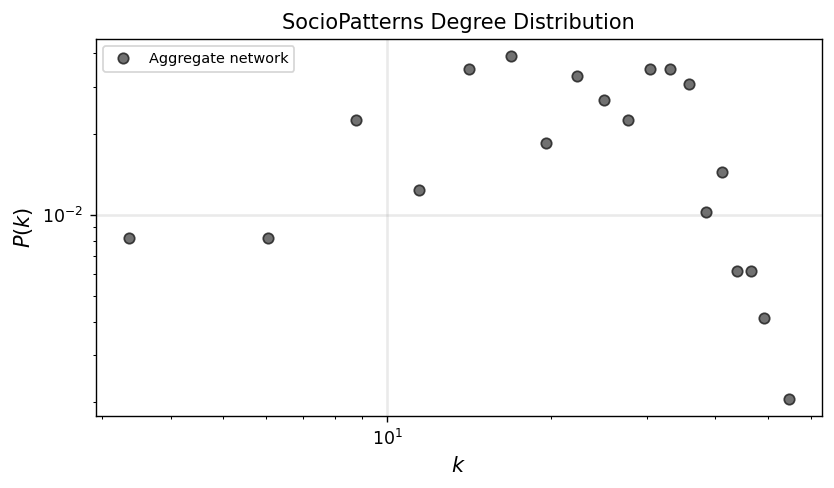

In [20]:
degrees = np.array(list(dict(G_agg.degree()).values()))
x_agg, y_agg = get_binning(degrees, num_bins=20)

fig, ax = plt.subplots(1,1,figsize=(7.5,4),dpi=125)

ax.loglog(x_agg, y_agg, 'o', color='.3', label='Aggregate network', alpha=0.8, mec='.1')

ax.set_xlabel(r"$k$",fontsize='large')
ax.set_ylabel(r"$P(k)$",fontsize='large')
ax.legend(fontsize='small')
ax.grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax.set_title('SocioPatterns Degree Distribution')

plt.show()

In [21]:
interval_sizes = [86400, 172800, 259200, 345600, 432000, 518400, 604800, 691200, 777600]
int_s = interval_sizes[0]
G_t = temporal_network_from_data(tdf, 
                                 aggregation="interval",  # Options: 'interval', 'custom', 'all'
                                 interval_size=int_s, # Size of the time interval for 'interval' aggregation
                                 time_window=None,  # Tuple (start, stop) to restrict aggregation to specific time range
                                 custom_slices=None,  # List of custom slice sizes for aggregation
                                 directed=False,  # Create directed graph
                                 multigraph=False,  # Create a MultiGraph or MultiDiGraph instead of Graph/DiGraph
                                 column_names=None)  # Required if `data` is a CSV or NumPy array

Gt_i = G_t[0]

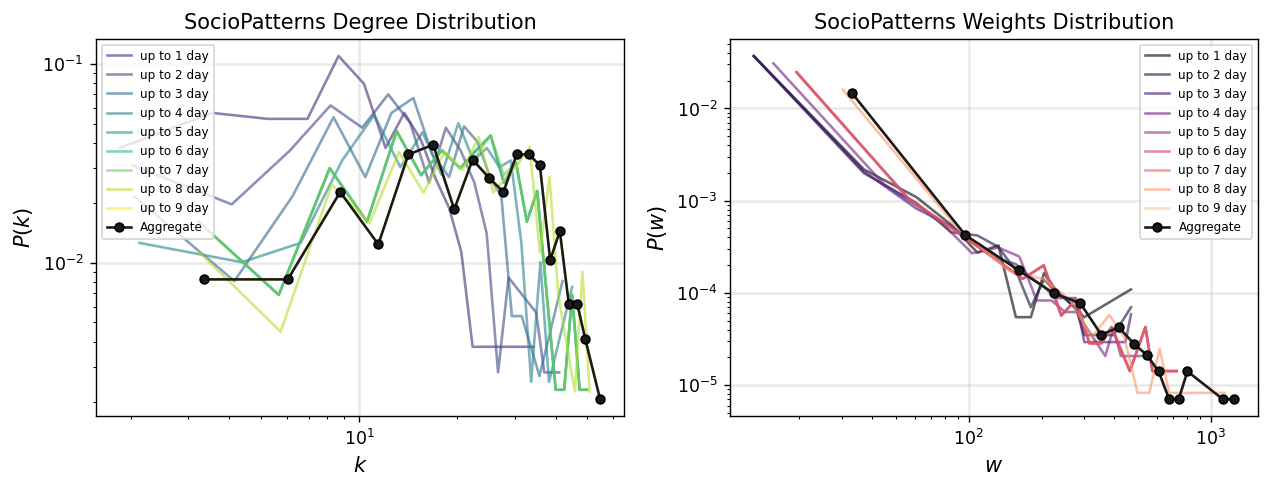

In [22]:
degrees = np.array(list(dict(G_agg.degree()).values()))
x_agg, y_agg = get_binning(degrees, num_bins=20)

weights_agg = np.array(list(nx.get_edge_attributes(G_agg, 'weight').values()))
xw_agg, yw_agg = get_binning(weights_agg, num_bins=20)

fig, ax = plt.subplots(1,2,figsize=(12,4),dpi=125)


interval_sizes = [86400, 172800, 259200, 345600, 432000, 518400, 604800, 691200, 777600]
cols = plt.cm.viridis(np.linspace(0,1,1+len(interval_sizes)))[1:]
colsw = plt.cm.magma(np.linspace(0,1,1+len(interval_sizes)))[:-1]
for i,int_s in enumerate(interval_sizes):
    Gt_i = temporal_network_from_data(tdf, aggregation="interval", interval_size=int_s)[0]    
    degrees_ti = np.array(list(dict(Gt_i.degree()).values()))
    x_ti, y_ti = get_binning(degrees_ti, num_bins=20)
    ax[0].loglog(x_ti, y_ti, '-', color=cols[i], label='up to %i day'%(i+1),
              alpha=0.6)
    weights_ti = np.array(list(nx.get_edge_attributes(Gt_i, 'weight').values()))
    xw_ti, yw_ti = get_binning(weights_ti, num_bins=20)
    ax[1].loglog(xw_ti, yw_ti, '-', color=colsw[i], label='up to %i day'%(i+1),
              alpha=0.6)
    
    
ax[0].loglog(x_agg, y_agg, '.-', color='.1', label='Aggregate', mec='.0', ms=10)
ax[1].loglog(xw_agg, yw_agg, '.-', color='.1', label='Aggregate', mec='.0', ms=10)

ax[0].set_xlabel(r"$k$",fontsize='large')
ax[0].set_ylabel(r"$P(k)$",fontsize='large')
ax[0].legend(fontsize='x-small',loc=2)
ax[0].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[0].set_title('SocioPatterns Degree Distribution')
ax[1].set_xlabel(r"$w$",fontsize='large')
ax[1].set_ylabel(r"$P(w)$",fontsize='large')
ax[1].legend(fontsize='x-small',loc=1)
ax[1].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[1].set_title('SocioPatterns Weights Distribution')


plt.show()

In [23]:
t_net = temporal_network_from_data(tdf, aggregation='interval')

In [24]:
nodes_events = dict()
for t in sorted(t_net.keys()):  # Iterate over sorted time bins
    graph = t_net[t]
    for node in graph.nodes():
        nodes_events.setdefault(node, []).append(t)  # Track event times per node

# Step 2: Calculate inter-event times for each node
event_ie_t = dict()
for node, event_list in nodes_events.items():  # Iterate over nodes and their event times
    for i in range(1, len(event_list)):
        ie_t = event_list[i] - event_list[i - 1]  # Calculate inter-event time
        event_ie_t.setdefault(event_list[i - 1], []).append(ie_t)  # Group by start time

# Step 3: Flatten the inter-event times for plotting
event_number = []
ie_time_list = []
counter = 0
for t in sorted(event_ie_t.keys()):  # Iterate over sorted event start times
    for ie_t in event_ie_t[t]:
        event_number.append(counter)  # Track event number
        ie_time_list.append(ie_t)  # Add inter-event time
        counter += 1

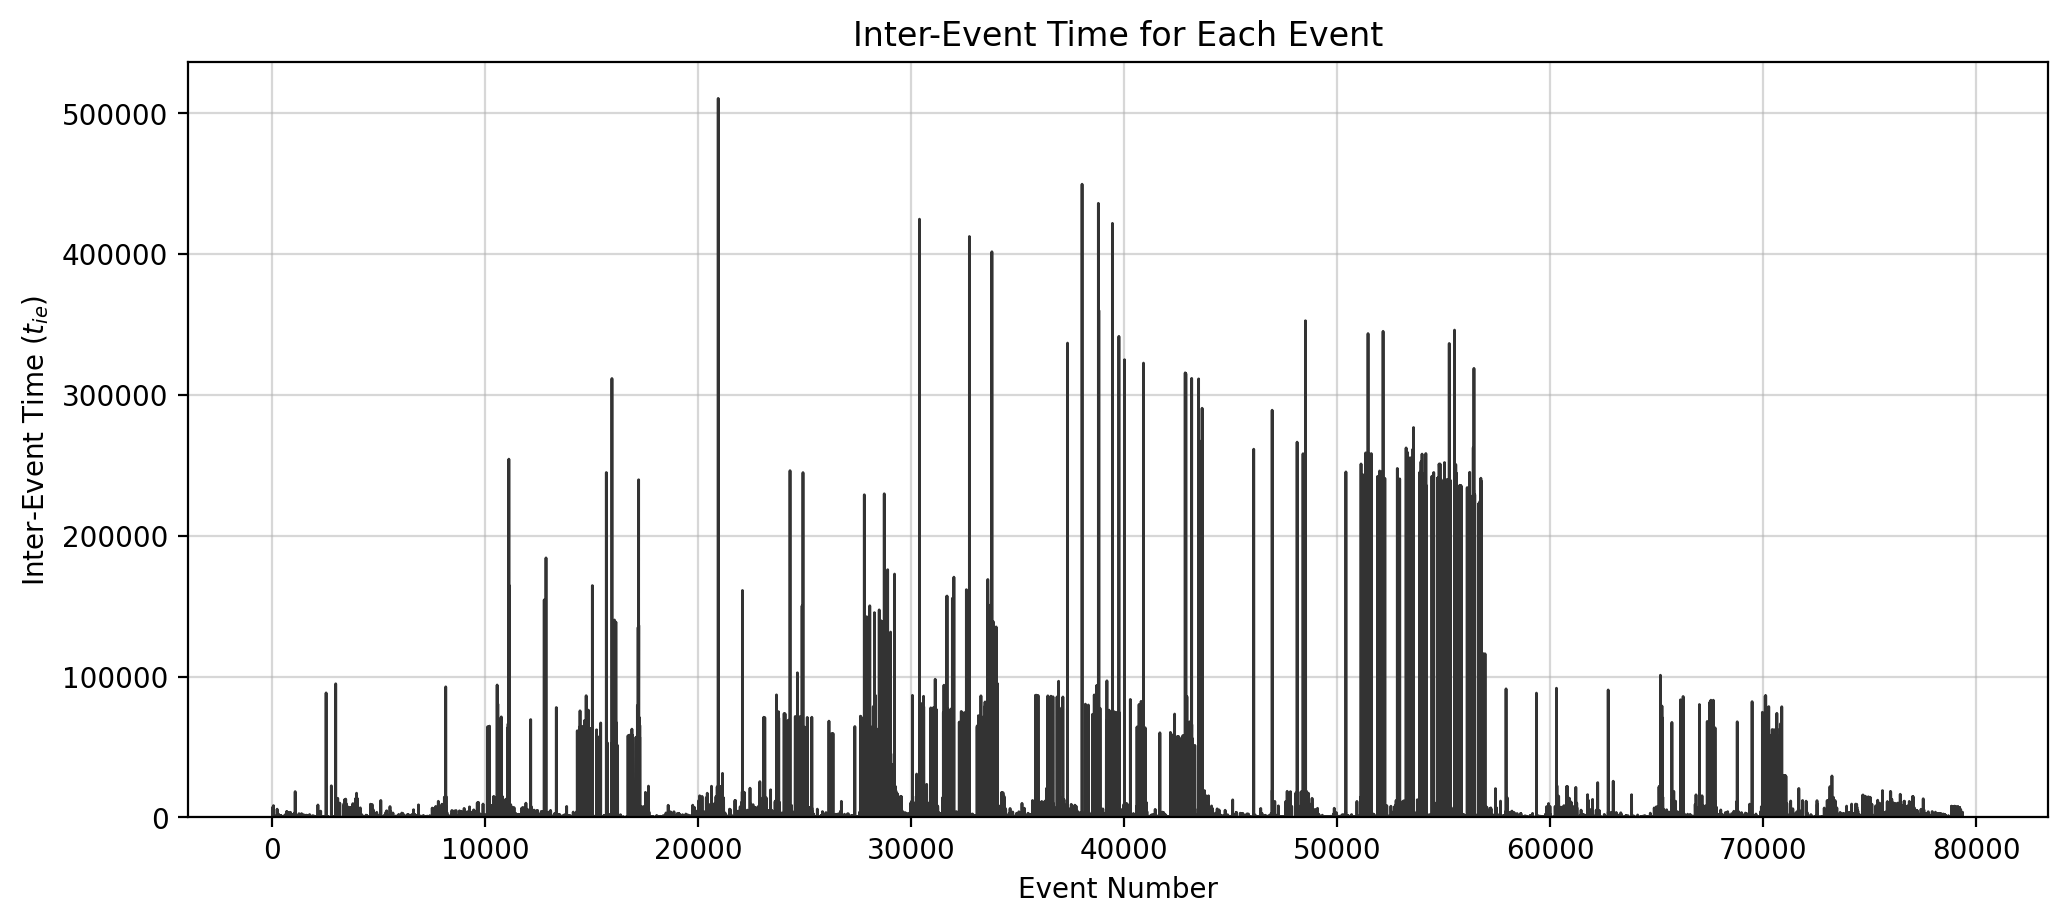

In [25]:
fig, ax = plt.subplots(1,1,figsize=(12,5),dpi=200)

ax.plot(event_number, ie_time_list, color='.2', lw=1)

ax.set_xlabel("Event Number")
ax.set_ylabel("Inter-Event Time ($t_{ie}$)")
ax.set_title("Inter-Event Time for Each Event")
ax.grid(alpha=0.5)
ax.set_ylim(0)
# ax.set_xlim(0, 80000)

plt.show()

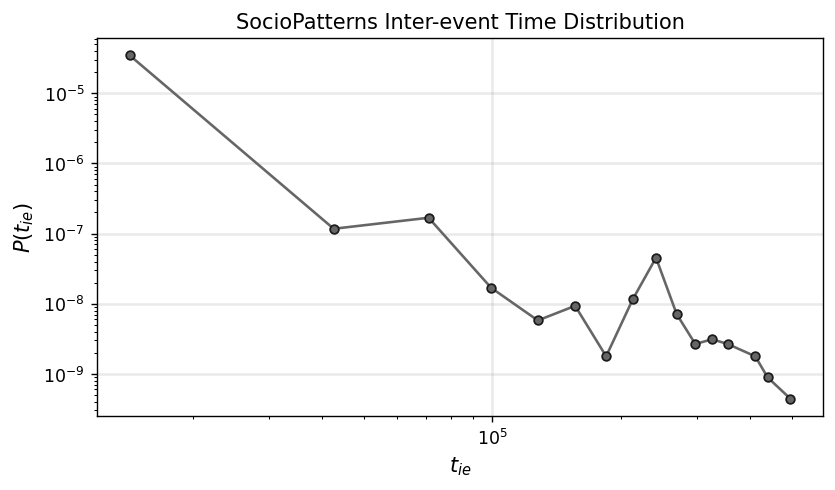

In [26]:
x_ie, y_ie = get_binning(ie_time_list, num_bins=18)

fig, ax = plt.subplots(1,1,figsize=(7.5,4),dpi=125)

ax.loglog(x_ie, y_ie, '.-', color='.4', mec='.1', ms=10)

ax.set_xlabel(r"$t_{ie}$",fontsize='large')
ax.set_ylabel(r"$P(t_{ie})$",fontsize='large')
ax.grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax.set_title('SocioPatterns Inter-event Time Distribution')

plt.show()

### Your turn!

Select two global network properties to analyze over time. Pick a timescale to view your network evolution, and create a plot with two subplots that track this property over time.

In [27]:
pass

_______
### Background and Introduction to Burstiness Index for Temporal Networks

Temporal networks are systems where interactions or connections between entities occur at specific times. Unlike static networks, temporal networks account for the timing and sequence of events, making them essential for understanding processes such as information diffusion, disease transmission, and human communication patterns.

One intriguing property of temporal networks is **burstiness**—the tendency of events to cluster in short periods of high activity, followed by long periods of inactivity. This phenomenon is observed across various domains, from human interactions (e.g., email exchanges, phone calls) to natural systems (e.g., neuronal firing, animal behavior).

#### Burstiness in Temporal Networks
Burstiness arises when the timing of events deviates from a uniform or random (Poissonian) distribution. In a random process, inter-event times (the time gaps between consecutive events) are typically distributed exponentially. However, real-world systems often exhibit heavy-tailed distributions, where a significant fraction of inter-event times are very short, interspersed with much longer intervals.

This non-random clustering of events has significant implications:
- **Efficiency**: Burstiness can accelerate or slow down dynamic processes like spreading phenomena.
- **Predictability**: It reflects underlying mechanisms governing the system, such as behavioral patterns or network constraints.
- **System Design**: Understanding burstiness helps optimize systems, from communication networks to epidemic models.



#### Burstiness Index
The **burstiness index** is a quantitative measure introduced to capture this deviation from randomness in temporal event sequences. It is defined based on the statistical properties of inter-event times.

For a sequence of inter-event times $ \{ \tau_1, \tau_2, \dots, \tau_n \} $, the burstiness index $ B $ is defined as:

$$ B = \frac{\sigma_\tau - \mu_\tau}{\sigma_\tau + \mu_\tau} $$

where:
- $ \mu_\tau $ is the mean of the inter-event times,
- $ \sigma_\tau $ is the standard deviation of the inter-event times.

The burstiness index $ B $ has the following properties:
- $ B = -1 $: Events are perfectly regular (e.g., periodic).
- $ B = 0 $: Events are Poissonian, with a random, exponential distribution of inter-event times.
- $ B > 0 $: Events are bursty, with a heavy-tailed distribution of inter-event times.

#### Intuition Behind the Formula
The burstiness index is designed to compare the variability ($ \sigma $) of inter-event times to their mean ($ \mu $):
- When $ \sigma \approx \mu $, the inter-event times are relatively uniform, and $ B $ approaches 0.
- When $ \sigma \gg \mu $, the variability dominates, indicating highly irregular event timing, and $ B $ becomes positive.
- When $ \sigma \ll \mu $, as in periodic systems, $ B $ becomes negative.



#### Applications of Burstiness Index
The burstiness index has been widely used to study temporal networks in various contexts:
1. **Social Networks**: Understanding the temporal patterns of human communication (e.g., email, messaging, phone calls).
2. **Biological Systems**: Analyzing neuronal firing patterns or animal behavior.
3. **Infrastructure Networks**: Characterizing traffic patterns or network usage in telecommunication systems.
4. **Epidemiology**: Modeling the timing of human interactions that drive disease spread.

#### Importance in Temporal Networks
In temporal networks, burstiness provides critical insights into the structure and dynamics of event sequences. For example:
- It influences how fast information or diseases propagate.
- It reveals behavioral rhythms and anomalies in human activity.
- It helps differentiate between natural and engineered systems.

The burstiness index is thus an essential tool for exploring and characterizing temporal networks, enabling researchers to identify deviations from randomness and uncover patterns underlying complex systems.

![](images/bursts_barabasi_nature2005.png)

![](images/srep00397-f1.jpg)

**References**
1. Barabási, AL. The origin of bursts and heavy tails in human dynamics. *Nature* 435, 207–211 (2005). https://doi.org/10.1038/nature03459
2. Goh, K. I., & Barabási, AL (2008). Burstiness and memory in complex systems. Europhysics Letters, 81(4), 48002. https://iopscience.iop.org/article/10.1209/0295-5075/81/48002
3. Karsai, M., Kaski, K., Barabási, AL. et al. Universal features of correlated bursty behaviour. *Sci Rep* 2, 397 (2012). https://doi.org/10.1038/srep00397

### Origin of burstiness? Queue Model

Possible causes? Heterogeneous distribution of priorities.

#### Priority List Model
1. Pick the task with the highest priority with probability $ p $, or randomly pick one with $ 1-p $, and execute it.
2. Generate a new task with a random priority.
| **Task** | **Priority** |
|----------|--------------|
| 1        | $ x_1 $    |
| 2        | $ x_2 $    |
| 3        | $ x_3 $    |
| 4        | $ x_4 $    |
| 5        | $ x_5 $    |
| 6        | $ x_6 $    |
| ...      | ...        |
| $ L $  | $ x_L $    |

The probability of executing a task is $\Pi(x) = \dfrac{x^{\gamma}}{\sum_{i=1\cdots L} x_i^{\gamma}}$.
- $\gamma = 0$: random ($p=0$)
- $\gamma = \infty$: determinsitic ($p=1$)

The average waiting time of a task with priority $x$ is executed $\tau(x) = \dfrac{1}{\Pi(x)} \sim x^{-\gamma}$.

In [28]:
def measure_burstiness(inter_event_times):
    """
    Calculate the burstiness index for a sequence of inter-event times.

    The burstiness index is defined as:
        B = (sigma - mu) / (sigma + mu)
    where:
        - sigma is the standard deviation of the inter-event times.
        - mu is the mean of the inter-event times.

    Parameters:
    ----------
    inter_event_times : array-like
        A sequence of inter-event times (time differences between consecutive events).

    Returns:
    -------
    float
        The burstiness index, where:
        - B = -1 indicates perfectly regular events.
        - B = 0 indicates Poissonian/random events.
        - B > 0 indicates bursty events.
    
    Raises:
    ------
    ValueError
        If the input array is empty or has insufficient data to calculate burstiness.
    """
    # Ensure the input is a valid array
    if len(inter_event_times) < 2:
        raise ValueError("At least two inter-event times are required to calculate burstiness.")
    
    # Compute mean and standard deviation
    mu = np.mean(inter_event_times)
    sigma = np.std(inter_event_times)

    # Avoid division by zero
    if sigma + mu == 0:
        return 0.0

    # Calculate and return the burstiness index
    return (sigma - mu) / (sigma + mu)

In [29]:
print("burstiness index = %.6f" % measure_burstiness(ie_time_list))

burstiness index = 0.810840


In [31]:
ts_length = 100000

# random_time_list = np.random.randint(0,100,ts_length)
random_time_list = np.random.poisson(size=ts_length)

periodic_time_list = [10] * ts_length

powerlaw_time_list = np.random.zipf(2.0, ts_length)

print("Periodic inter-event times:\tBurstiness = %.3f"%measure_burstiness(periodic_time_list))
print("Random inter-event times:\tBurstiness =  %.3f"%measure_burstiness(random_time_list))
print("Powerlaw inter-event times:\tBurstiness =  %.3f"%measure_burstiness(powerlaw_time_list))


Periodic inter-event times:	Burstiness = -1.000
Random inter-event times:	Burstiness =  0.001
Powerlaw inter-event times:	Burstiness =  0.980


____________
## Activity-Driven Network Model (if there's time!)

The **Activity-Driven Network Model** is a widely used framework for studying dynamic networks, where the structure evolves over time based on the intrinsic activity levels of nodes. Unlike static networks, where connections remain fixed, activity-driven networks capture the temporal nature of interactions, making them suitable for analyzing systems such as social interactions, communication patterns, and information diffusion.


### Key Features of the Model
The activity-driven network model assumes that each node in the network is characterized by an **activity rate** $ a_i $, which determines the probability that the node becomes active in a given time step. When a node becomes active, it forms temporary edges with other nodes in the network. These edges exist only for the duration of the time step, reflecting the transient nature of interactions in many real-world systems.

At each time step:
1. **Node Activation**: Each node becomes active with a probability proportional to its activity rate $ a_i $.
2. **Edge Formation**: Active nodes form $ m $ connections with other randomly selected nodes in the network.
3. **Temporal Graph**: The resulting network for the time step is recorded as a temporal graph.
4. **Aggregation**: Over multiple time steps, an aggregated network is constructed, representing all the edges formed throughout the simulation.

---

### Model Parameters
The activity-driven network model is controlled by the following parameters:
- $ N $: The number of nodes in the network.
- $ T $: The number of time steps over which the network evolves.
- $ m $: The number of edges each active node creates per time step.
- $ a_i $: The activity rate of node $ i $, sampled from a specified **activity distribution** (e.g., uniform or power-law).

The choice of the activity distribution is crucial, as it can reflect heterogeneous or homogeneous activity patterns. For example:
- A **uniform distribution** implies that all nodes have similar probabilities of becoming active.
- A **power-law distribution** assigns higher activity rates to a few nodes, reflecting real-world systems where a small subset of nodes drives most interactions.

---

#### Applications
The activity-driven network model is versatile and has been applied in various domains:
1. **Social Networks**: Simulating interactions in human systems, such as email exchanges or face-to-face contact.
2. **Epidemiology**: Modeling the spread of infectious diseases, where temporary connections between individuals facilitate disease transmission.
3. **Infrastructure**: Understanding communication or transportation networks, where connections appear dynamically over time.
4. **Information Diffusion**: Capturing how information propagates through dynamic networks.

By explicitly modeling the temporal dynamics of networks, this approach provides a powerful tool for studying processes that unfold over time, such as epidemic outbreaks, cascades, and synchronization phenomena.


_________ 
* N nodes
* each node has an activity potential $x$, extracted from a distribution $F(x)$

### Model dynamics:

1. At each time step $t$ the network $G_t$ starts with $N$ disconnected nodes
2. The node $i$ fires with probability $a_i \Delta t$, where $a_i = \eta x_i$ and $\eta$ is a recaling factor
3. Each active node generates $m$ links connecting to $m$ other randomly selected nodes (could be either active or non-active)
4. At next time step $t+\Delta t$, all links in $G_t$ are deleted. Go to step I.

Notes:
- $a_i = \eta x_i$ : Probability per unit time to create new connections with other nodes
- $\epsilon \leq x_i \leq 1 $
- The average number of active nodes per unit time is $\eta \langle x \rangle N$

Therefore:
- Total number of edges per unit time: $E_t = mN\eta\langle x \rangle$
- The average degree per unit time: $$k_t = \frac{2E_t}{N} = 2m\eta\langle x \rangle$$
- At time $T$, on the aggregated network up to time $T$, the degree of node $i$: $$k_i(T)=N(1-e^{Tm\eta x_i/N})$$
- So the degree distribution for the aggregated network up to time $T$: $$P_T(k) \sim F\Big [ \frac{k}{Tm\eta} \Big ]$$


**References**
1. Perra, N., Gonçalves, B., Pastor-Satorras, R. et al. Activity driven modeling of time varying networks. *Sci Rep* 2, 469 (2012). https://doi.org/10.1038/srep00469
2. Perra, N., Baronchelli, A., Mocanu, D., Gonçalves, B., Pastor-Satorras, R., & Vespignani, A. (2012). Random walks and search in time-varying networks. *Physical Review Letters*, 109(23), 238701. https://doi.org/10.1103/PhysRevLett.109.238701

In [32]:
def activity_driven_network(N, T, m, activity_distribution, plot=False):
    """
    Simulate an activity-driven network model.

    Parameters:
    ----------
    N : int
        Number of nodes in the network.
    T : int
        Number of time steps to simulate.
    m : int
        Number of edges each active node forms at each time step.
    activity_distribution : callable
        A function that generates activity rates for the nodes.
        Example: lambda: np.random.uniform(0, 1) for uniform distribution.
    plot : bool, optional
        Whether to plot the final aggregated network. Default is False.

    Returns:
    -------
    G_agg : networkx.Graph
        The aggregated graph over all time steps.
    G_t_list : list of networkx.Graph
        A list of temporal graphs (one for each time step).
    """

    # Step 1: Initialize nodes with activity rates
    activity_rates = np.array([activity_distribution() for _ in range(N)])
    nodes = list(range(N))

    # Step 2: Create an empty aggregated graph
    G_agg = nx.Graph()

    # Step 3: Initialize list to store temporal graphs
    G_t_list = []

    # Step 4: Simulate the network over T time steps
    for t in range(T):
        # Create a new graph for the current time step
        G_t = nx.Graph()
        G_t.add_nodes_from(nodes)

        # Determine active nodes
        active_nodes = [node for node in nodes if np.random.rand() < activity_rates[node]]

        # Create connections for each active node
        for node in active_nodes:
            # Choose m distinct nodes to connect to
            targets = np.random.choice(nodes, size=m, replace=False)
            for target in targets:
                G_t.add_edge(node, target)
                G_agg.add_edge(node, target)  # Update the aggregated graph

        # Store the temporal graph for the current time step
        G_t_list.append(G_t)


    return G_agg, G_t_list

In [33]:
# Example parameters
N = 100  # Number of nodes
T = 50   # Number of time steps
m = 3    # Number of edges per active node
activity_distribution = lambda: np.random.uniform(0.1, 0.5)  # Uniform distribution of activity rates

# Simulate the activity-driven network
G_agg, G_t_list = activity_driven_network(N, T, m, activity_distribution, plot=True)

# Print basic stats
print(f"Aggregated Network: {G_agg.number_of_nodes()} nodes, {G_agg.number_of_edges()} edges")
print(f"Temporal Graphs: {len(G_t_list)} time steps")


Aggregated Network: 100 nodes, 3049 edges
Temporal Graphs: 50 time steps



__________
## Next time...
Spatial Data, OSMNX, GeoPandas `class_24_spatial.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Jupyter Book: https://asmithh.github.io/network-science-data-book/intro.html
    - Github: https://github.com/asmithh/network-science-data-book
    - Syllabus and course details: https://brennanklein.com/phys7332-fall24
2. Cattuto, C., Van den Broeck, W., Barrat, A., Colizza, V., Pinton, J. F., & Vespignani, A. (2010). Dynamics of person-to-person interactions from distributed RFID sensor networks. *PloS One*, 5(7), e11596. https://doi.org/10.1371/journal.pone.0011596
3. Starnini, M., Baronchelli, A., & Pastor-Satorras, R. (2013). Modeling human dynamics of face-to-face interaction networks. *Physical Review Letters*, 110(16), 168701. https://doi.org/10.1103/PhysRevLett.110.168701
4. Barabási, AL. The origin of bursts and heavy tails in human dynamics. *Nature* 435, 207–211 (2005). https://doi.org/10.1038/nature03459
5. Perra, N., Gonçalves, B., Pastor-Satorras, R. et al. Activity driven modeling of time varying networks. *Sci Rep* 2, 469 (2012). https://doi.org/10.1038/srep00469
6. Perra, N., Baronchelli, A., Mocanu, D., Gonçalves, B., Pastor-Satorras, R., & Vespignani, A. (2012). Random walks and search in time-varying networks. *Physical Review Letters*, 109(23), 238701. https://doi.org/10.1103/PhysRevLett.109.238701
7. Barabási, AL. The origin of bursts and heavy tails in human dynamics. *Nature* 435, 207–211 (2005). https://doi.org/10.1038/nature03459
8. Goh, K. I., & Barabási, A. L. (2008). Burstiness and memory in complex systems. Europhysics Letters, 81(4), 48002. https://iopscience.iop.org/article/10.1209/0295-5075/81/48002
9. Karsai, M., Kaski, K., Barabási, AL. et al. Universal features of correlated bursty behaviour. *Sci Rep* 2, 397 (2012). https://doi.org/10.1038/srep00397